# Estudo de caso: previsão de vendas

Nesse estudo vamos fazer uma análise exploratória de dados de vendas, onde cada linha do conjunto contém informações de venda de um determinado item, associadas a ciclos temporais. As colunas de nosso dataset são:

- COD_MATERIAL            Código do produto
- COD_CICLO               Ciclo (variável de tempo)
- DES_CATEGORIA_MATERIAL  Categoria do produto
- DES_MARCA_MATERIAL      Marca do Produto
- FLG_DATA                Indicador de existência ou não de datas comemorativas no ciclo
- FLG_CAMPANHA_MKT_A      Indicador de existência ou não da campanha de marketing A no ciclo
- FLG_CAMPANHA_MKT_B      Indicador de existência ou não da campanha de marketing B no ciclo
- FLG_CAMPANHA_MKT_C      Indicador de existência ou não da campanha de marketing C no ciclo
- FLG_CAMPANHA_MKT_D      Indicador de existência ou não da campanha de marketing D no ciclo
- FLG_CAMPANHA_MKT_E      Indicador de existência ou não da campanha de marketing E no ciclo
- FLG_CAMPANHA_MKT_F      Indicador de existência ou não da campanha de marketing E no ciclo
- PCT_DESCONTO            Percentual de desconto aplicado na venda (0 - 100)
- VL_PRECO                Preço do produto
- QT_VENDA                Quantidade vendida

O objetivo é prever a quantidade vendida de cada item em 3 ciclos específicos: 202016, 202017 e 202101.


Este notebook também contém uma seção de pré-processamento dos dados e diferentes experimentos associados a diferentes abordagens de treinamento de algoritmos de machine learning, na tentativa de encontrar um modelo que apresente uma boa performance quando comparado aos outros. A partir desta exploração construíremos os scripts de pré-processamento, treino e inferência, para possibilitar futuras automações e inferência para novos dados.

## Análise Exploratória

In [1]:
import pandas as pd 
from pandas.plotting import autocorrelation_plot
import numpy as np 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error

import xgboost as xgb

sns.set_style("whitegrid")

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and 

In [2]:
df = pd.read_csv('output.csv')
df.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
0,6246,201908,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0
1,6246,201915,anon_S12,anon_S53,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0
2,6306,201916,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,521.4,240.0
3,6480,201801,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,528.0
4,6480,201802,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,564.0


In [3]:
df.shape

(52094, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52094 entries, 0 to 52093
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   COD_MATERIAL            52094 non-null  int64  
 1   COD_CICLO               52094 non-null  int64  
 2   DES_CATEGORIA_MATERIAL  52094 non-null  object 
 3   DES_MARCA_MATERIAL      52094 non-null  object 
 4   FLG_DATA                52094 non-null  int64  
 5   FLG_CAMPANHA_MKT_A      52094 non-null  float64
 6   FLG_CAMPANHA_MKT_B      52094 non-null  float64
 7   FLG_CAMPANHA_MKT_C      52094 non-null  float64
 8   FLG_CAMPANHA_MKT_D      52094 non-null  float64
 9   FLG_CAMPANHA_MKT_E      52094 non-null  float64
 10  FLG_CAMPANHA_MKT_F      52094 non-null  float64
 11  PCT_DESCONTO            16780 non-null  float64
 12  VL_PRECO                52088 non-null  float64
 13  QT_VENDA                48946 non-null  float64
dtypes: float64(9), int64(3), object(2)
mem

In [5]:
df.isna().sum()

COD_MATERIAL                  0
COD_CICLO                     0
DES_CATEGORIA_MATERIAL        0
DES_MARCA_MATERIAL            0
FLG_DATA                      0
FLG_CAMPANHA_MKT_A            0
FLG_CAMPANHA_MKT_B            0
FLG_CAMPANHA_MKT_C            0
FLG_CAMPANHA_MKT_D            0
FLG_CAMPANHA_MKT_E            0
FLG_CAMPANHA_MKT_F            0
PCT_DESCONTO              35314
VL_PRECO                      6
QT_VENDA                   3148
dtype: int64

Vemos que a variável 'PCT_DESCONTO' possui cerca de 68% de dados faltantes. Já nosso target, a variável 'QT_VENDA', possui 3148 dados faltantes. Observe também que as variáveis flag são do tipo float, mas descrevem variáveis de natureza categórica. Por isso, ao analisarmos correlação e propriedades como média, std, e outras, consideraremos somente as variáveis intrinsicamente do tipo numérico.

In [6]:
df[['PCT_DESCONTO', 'VL_PRECO', 'QT_VENDA']].corr()

,PCT_DESCONTO,VL_PRECO,QT_VENDA
PCT_DESCONTO,1.000000,-0.031468,0.006591
VL_PRECO,-0.031468,1.000000,0.100871
QT_VENDA,0.006591,0.100871,1.000000


Aqui podemos observar uma correlação baixa entre preço e quantidade de venda, ou seja, não necessariamente itens mais baratos venderão mais.

In [7]:
df[['PCT_DESCONTO', 'VL_PRECO', 'QT_VENDA']].describe().T

,count,mean,std,min,25%,50%,75%,max
PCT_DESCONTO,16780.0,19.461982,77.696194,0.00,15.0,20.0,25.035,10000.00
VL_PRECO,52088.0,544.998243,250.925173,234.06,389.4,461.4,593.400,5539.62
QT_VENDA,48946.0,34004.046275,98123.669055,235.00,810.0,5880.0,29964.000,4047372.00


Pelas descritiva acima, podemos ver que a variável 'pct_desconto' possui outliers. Mas não vamos nos preocupar com essa questão, pois no pré processamento ela será descartada por conter muitos valores faltantes. Vamos agora analisar a distribuição das demais variáveis.

In [8]:
df['DES_CATEGORIA_MATERIAL'].value_counts()

anon_S5     14053
anon_S2     12870
anon_S12    12828
anon_S11     7018
anon_S18     3120
anon_S30     2205
Name: DES_CATEGORIA_MATERIAL, dtype: int64

In [9]:
df['DES_MARCA_MATERIAL'].value_counts()

anon_S8     10302
anon_S24     7361
anon_S23     3649
anon_S22     3513
anon_S20     3333
            ...  
anon_S92        1
anon_S80        1
anon_S87        1
anon_S82        1
anon_S84        1
Name: DES_MARCA_MATERIAL, Length: 85, dtype: int64

Vamos que esta última feature possui uma cardinalidade alta. Vamos, por agora, considerar apenas os 10 valores mais frequentes, e agrupar os demais em uma única categoria chamada 'other'.

In [10]:
counts = df['DES_MARCA_MATERIAL'].value_counts()
to_group = counts[counts < 1525].index.tolist()
df['DES_MARCA_MATERIAL'] = df['DES_MARCA_MATERIAL'].replace(to_group, 'Other')

In [11]:
df['DES_MARCA_MATERIAL'].value_counts()

Other       13844
anon_S8     10302
anon_S24     7361
anon_S23     3649
anon_S22     3513
anon_S20     3333
anon_S17     2347
anon_S21     2282
anon_S6      2039
anon_S9      1898
anon_S4      1526
Name: DES_MARCA_MATERIAL, dtype: int64

In [12]:
df['COD_CICLO'].nunique()

53

In [13]:
df['COD_CICLO'].sort_values().unique()

array([201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
       201809, 201810, 201811, 201812, 201813, 201814, 201815, 201816,
       201817, 201818, 201901, 201902, 201903, 201904, 201905, 201906,
       201907, 201908, 201909, 201910, 201911, 201912, 201913, 201914,
       201915, 201916, 201917, 202001, 202002, 202003, 202004, 202005,
       202006, 202007, 202008, 202009, 202010, 202011, 202012, 202013,
       202014, 202015, 202016, 202017, 202101])

In [14]:
df[df['QT_VENDA'].isna()]['COD_CICLO'].value_counts()

202017    1053
202016    1049
202101    1046
Name: COD_CICLO, dtype: int64

Aqui vemos que os dados faltantes em 'QT_VENDA' se referem aos ciclos para os quais queremos fazer as previsões. Portanto, não temos o ground-truth associado a estes ciclos.

In [15]:
# categorizing the campaing variables in order to plot their distribution
df_cat = df.loc[:,['FLG_CAMPANHA_MKT_A', 'FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D', 'FLG_CAMPANHA_MKT_E', 'FLG_CAMPANHA_MKT_F']]
df_cat['CAMPANHA_MKT'] = df_cat.idxmax(axis=1)
df_cat['CAMPANHA_MKT'].value_counts()

FLG_CAMPANHA_MKT_A    36124
FLG_CAMPANHA_MKT_B    13577
FLG_CAMPANHA_MKT_D     2213
FLG_CAMPANHA_MKT_C      180
Name: CAMPANHA_MKT, dtype: int64

Note que não há registros correspondentes às campanhas E e F.

In [16]:
# função que plota a distribuição das variáveis categóricas
def plot_distr(var, n_row, n_col, title, rotation, data, hue = None):
    f = sns.countplot(ax = axes[n_row, n_col], x = var, data = data, hue = hue, order = data[var].value_counts().index)
    f.set(title = title, ylabel = 'Frequência Absoluta')
    f.tick_params(axis="x", rotation = rotation)
    return None

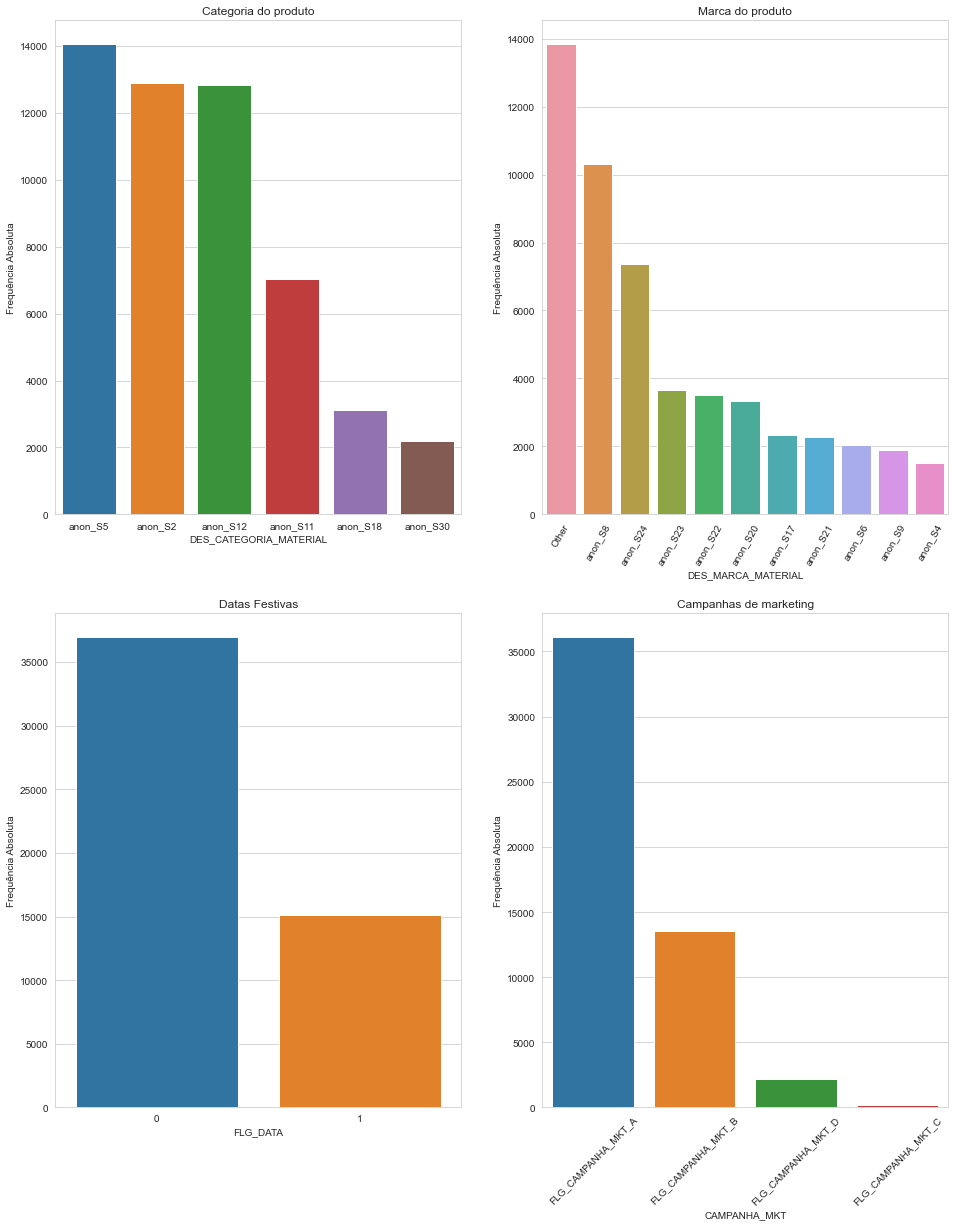

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 20))
plot_distr('DES_CATEGORIA_MATERIAL', 0, 0, 'Categoria do produto', 0, df)
plot_distr('DES_MARCA_MATERIAL', 0, 1, 'Marca do produto', 60, df)
plot_distr('FLG_DATA', 1, 0, 'Datas Festivas', 0, df)
plot_distr('CAMPANHA_MKT', 1, 1, 'Campanhas de marketing', 45, df_cat)

Vamos fazer agora uma análise bivariada para entender como variam preço e quantidade vendida.

<AxesSubplot:xlabel='QT_VENDA', ylabel='VL_PRECO'>

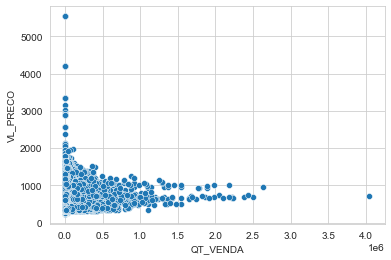

In [18]:
sns.scatterplot(data=df, x='QT_VENDA', y='VL_PRECO')

Vemos que parece não haver uma correlação significativa entre essas variáveis. Agora, vamos avaliar o comportamento temporal da quantidade de vendas.

In [19]:
df_no_sale = df[df['QT_VENDA']==0.0]
df_no_sale.shape

(0, 14)

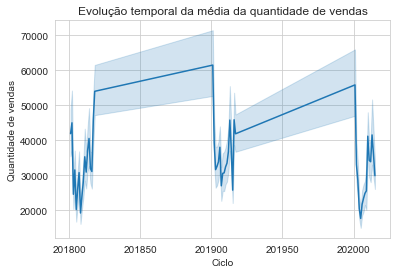

In [20]:
f = sns.lineplot(data= df, x='COD_CICLO', y='QT_VENDA')
f.set(title = 'Evolução temporal da média da quantidade de vendas', xlabel = 'Ciclo', ylabel = 'Quantidade de vendas')
plt.show()

Vamos checar se esta série temporal é estacionária, como aparenta ser, após tratamento dos dados faltantes. Utilizaremos para tanto o teste ADF (Augmented Dickey-Fuller). Por hora vamos checar como a série se comporta em ciclos com dias festivos versus ciclos sem dias festivos.

In [21]:
df_festa = df[df['FLG_DATA']==1]
df_festa.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
0,6246,201908,anon_S12,Other,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.40,240.0
2,6306,201916,anon_S12,Other,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,521.40,240.0
9,6480,201807,anon_S12,anon_S17,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,798.18,678.0
11,6480,201809,anon_S12,anon_S17,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.40,498.0
16,6528,201908,anon_S12,Other,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,403.50,240.0


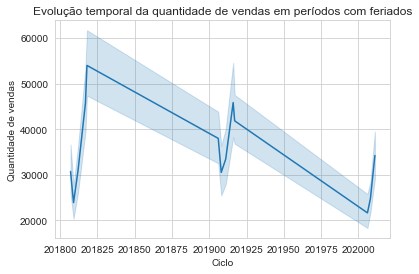

In [22]:
f = sns.lineplot(data= df_festa, x='COD_CICLO', y='QT_VENDA')
f.set(title = 'Evolução temporal da quantidade de vendas em períodos com feriados', xlabel = 'Ciclo', ylabel = 'Quantidade de vendas')
plt.show()

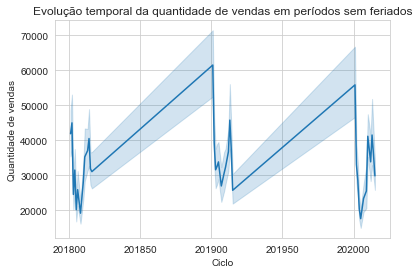

In [23]:
df_normal = df[df['FLG_DATA']!=1]
f = sns.lineplot(data= df_normal, x='COD_CICLO', y='QT_VENDA')
f.set(title = 'Evolução temporal da quantidade de vendas em períodos sem feriados', xlabel = 'Ciclo', ylabel = 'Quantidade de vendas')
plt.show()

Podemos notar comportamentos distintos em ambos os casos com relação a quantidade de vendas, o que pode induzir uma sazonalidade na série.

## Pré-processamento e engenharia de features

Primeiramente vamos eliminar a coluna 'PCT_DESCONTO' devido ao fato de possuir a maior parte de registros com valor faltante e a coluna 'COD_MATERIAL' por não trazer informação relevante para a análise.

In [24]:
df_no_missing = df.drop({'PCT_DESCONTO', 'COD_MATERIAL'}, axis=1)
df_no_missing.isna().sum()

COD_CICLO                    0
DES_CATEGORIA_MATERIAL       0
DES_MARCA_MATERIAL           0
FLG_DATA                     0
FLG_CAMPANHA_MKT_A           0
FLG_CAMPANHA_MKT_B           0
FLG_CAMPANHA_MKT_C           0
FLG_CAMPANHA_MKT_D           0
FLG_CAMPANHA_MKT_E           0
FLG_CAMPANHA_MKT_F           0
VL_PRECO                     6
QT_VENDA                  3148
dtype: int64

In [25]:
df_no_missing.dropna(inplace=True)
df_no_missing.isna().sum()

COD_CICLO                 0
DES_CATEGORIA_MATERIAL    0
DES_MARCA_MATERIAL        0
FLG_DATA                  0
FLG_CAMPANHA_MKT_A        0
FLG_CAMPANHA_MKT_B        0
FLG_CAMPANHA_MKT_C        0
FLG_CAMPANHA_MKT_D        0
FLG_CAMPANHA_MKT_E        0
FLG_CAMPANHA_MKT_F        0
VL_PRECO                  0
QT_VENDA                  0
dtype: int64

In [26]:
len(df_no_missing)

48940

In [27]:
df_no_missing.set_index('COD_CICLO', inplace=True)
df_no_missing.sort_index(inplace=True)

In [28]:
from statsmodels.tsa.stattools import adfuller
est = adfuller(df_no_missing['QT_VENDA'])

In [29]:
print('ADF Statistic:', est[0])
print('p-value:', est[1])

ADF Statistic: -24.556136170336043
p-value: 0.0


Como o p-value é nulo, podemos assumir que a série é estacionária.

In [30]:
msk = (df_no_missing.index < 202010)
df_train = df_no_missing[msk].copy()
df_test = df_no_missing[~msk].copy()
df_test.shape

(6089, 11)

In [31]:
df_train.index.unique()

Int64Index([201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
            201809, 201810, 201811, 201812, 201813, 201814, 201815, 201816,
            201817, 201818, 201901, 201902, 201903, 201904, 201905, 201906,
            201907, 201908, 201909, 201910, 201911, 201912, 201913, 201914,
            201915, 201916, 201917, 202001, 202002, 202003, 202004, 202005,
            202006, 202007, 202008, 202009],
           dtype='int64', name='COD_CICLO')

In [32]:
df_train.index.nunique()

44

## Modelagem preditiva: ARIMA vs XGBoost



In [33]:
series = df_train.loc[:, 'QT_VENDA']
series

COD_CICLO
201801    355218.0
201801      1140.0
201801       480.0
201801     50142.0
201801     85554.0
            ...   
202009    119214.0
202009     11490.0
202009       486.0
202009      1866.0
202009      1068.0
Name: QT_VENDA, Length: 42851, dtype: float64

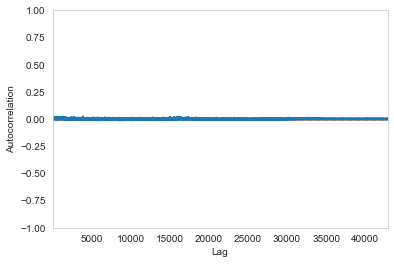

In [34]:
autocorrelation_plot(series)
plt.show()

Pelo gráfico acima percebemos que praticamente não há auto-correlação, indidicando que o parâmetro p, ou a componente AR do método, pode ser escolhida como nula.

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


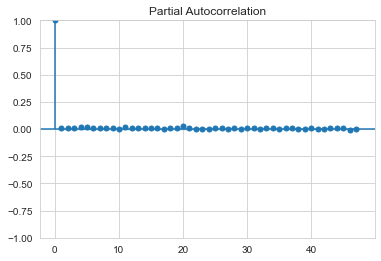

In [35]:
pacf_original = plot_pacf(series)

### Experimento 1

In [36]:
# usanto auto-arima para a escolha dos parâmetros de ordem
#import pmdarima as pm
#auto_arima = pm.auto_arima(series, seasonal=True)
#auto_arima

In [37]:
#model = sm.tsa.SARIMAX(series, order=(5, 1, 0), seasonal_order=(0, 0, 0, 34))
model = ARIMA(series, order=(5,1,0))

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [38]:
results = model.fit()

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               QT_VENDA   No. Observations:                42851
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -555600.080
Date:                Thu, 06 Apr 2023   AIC                        1111212.161
Time:                        17:45:43   BIC                        1111264.153
Sample:                             0   HQIC                       1111228.565
                              - 42851                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8377      0.002   -370.880      0.000      -0.842      -0.833
ar.L2         -0.6739      0.003   -233.824      0.000      -0.680      -0.668
ar.L3         -0.5066      0.003   -166.942      0.000      -0.513      -0.501
ar.L4         -0.3343      0.003   -116.859      0.000      -0.340      -0.329
ar.L5         -0.1619      0.002    -71.262      0.000      -0.166      -0.157
sigma2      1.071e+10   1.18e-14   9.06e+23      0.000    1.07e+10    1.07e+10
===================================================================================
Ljung-Box (L1) (Q):                  23.05   Jarque-Bera (JB):          19741072.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             7.26
Prob(H) (two-sided):                  0.00   Kurtosis:                       107.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.37e+39. Standard errors may be unstable.
"""

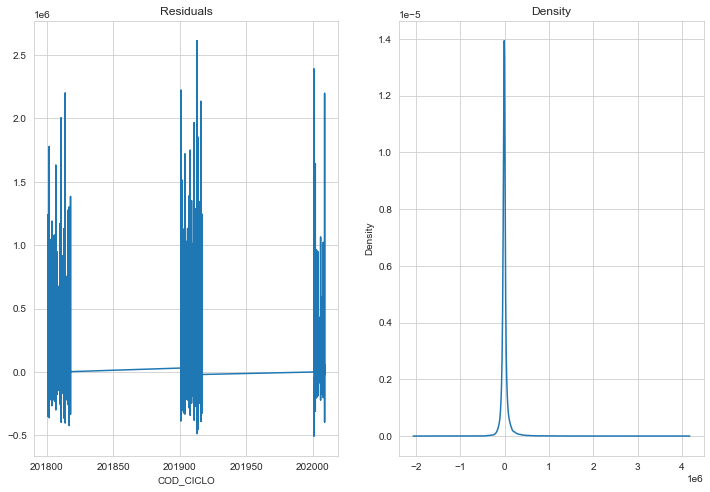

In [40]:
residuals = results.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(12,8))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [41]:
print(residuals.describe())

count    4.285000e+04
mean    -1.235019e+01
std      1.034910e+05
min     -5.060657e+05
25%     -2.849348e+04
50%     -1.017727e+04
75%      6.644992e+03
max      2.613855e+06
dtype: float64


### Avaliação do modelo

In [42]:
#ground-truth
series_test = df_test.loc[:, 'QT_VENDA']
series_test

COD_CICLO
202010    127662.0
202010      1632.0
202010    211644.0
202010     30330.0
202010     24072.0
            ...   
202015       240.0
202015    166968.0
202015     88980.0
202015      2568.0
202015     13314.0
Name: QT_VENDA, Length: 6089, dtype: float64

In [43]:
#predicted values
forecast = results.forecast(len(series_test))
print(f'Valor mínimo predito: {forecast.min()}')
print(f'Valor máximo predito: {forecast.max()}')
forecast = forecast.reset_index(drop=True)
print(forecast.head())

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Valor mínimo predito: 10351.568834115407
Valor máximo predito: 25614.980080007324
0    23212.287948
1    25614.980080
2    10404.063398
3    10351.568834
4    12155.403136
Name: predicted_mean, dtype: float64


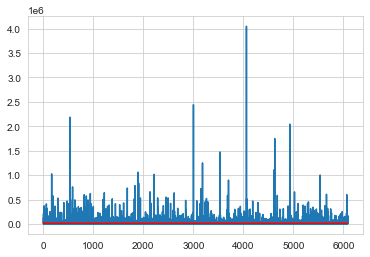

In [44]:
plt.plot(series_test.values)
plt.plot(forecast, color='red')
plt.show()

In [45]:
pred_ci = results.conf_int()
pred_ci

,0,1
ar.L1,-8.421551e-01,-8.333009e-01
ar.L2,-6.795149e-01,-6.682179e-01
ar.L3,-5.125973e-01,-5.007008e-01
ar.L4,-3.398738e-01,-3.286611e-01
ar.L5,-1.663168e-01,-1.574130e-01
sigma2,1.071026e+10,1.071026e+10


In [46]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(series_test, forecast)
mape = mean_absolute_percentage_error(series_test, forecast)
rmse = np.sqrt(mean_squared_error(series_test, forecast))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 34119.698878151
mape: 9.686110268735398
rmse: 111541.67218381405


Como vemos acima, o modelo não descreve bem nossos dados. Provavelmente isso se deve ao fato de termos múltiplas linhas por item. Assim, faria mais sentido construírmos uma série temporal para cada item, o que fica inviável. Sendo assim, vamos tentar uma nova abordagem, onde vamos treinar um novo modelo para cada ciclo, e depois pegamos a média do forecast de cada ciclo para compor o forecast de novos ciclos.

### Experimento 2

In [47]:
groups = series.groupby(series.index)
test_groups = series_test.groupby(series_test.index)

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Fit an ARIMA model for each group
models = {}
for name, group in groups:
    model = ARIMA(group, order=(2, 1, 0))
    results = model.fit()
    models[name] = results

In [50]:
forecast_group = {}
for key in models.keys():
        model = models[key]
        forecast = model.forecast(steps=len(group))
        forecast_group[key] = forecast
len(np.mean(list(forecast_group.values()), axis=0))

997

In [51]:
forecast_values = {}
forecast_group = {}
for name, group in test_groups:
    for key in models.keys():
        model = models[key]
        forecast = model.forecast(steps=len(group))
        forecast_group[key] = forecast
    forecast_values[name] = np.mean(list(forecast_group.values()), axis=0)

# Combine the forecasts for each cycle
forecasted_values = np.concatenate(list(forecast_values.values()))

# Print the length of forecasted values
print(len(forecasted_values))

6089


Test RMSE: 109318.5956096073
Test mae: 40935.842021123695


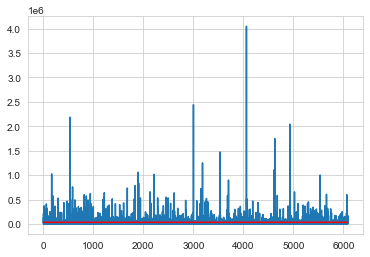

In [52]:
rmse = np.sqrt(mean_squared_error(series_test, forecasted_values))
mae = mean_absolute_error(series_test, forecasted_values)
print(f'Test RMSE: {rmse}')
print(f'Test mae: {mae}')
plt.plot(series_test.values)
plt.plot(forecasted_values, color='red')
plt.show()

### Experimento 3: XGBoost

In [72]:
df_xgb = df_no_missing.copy()
df_xgb.reset_index(inplace=True)
df_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48940 entries, 0 to 48939
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   COD_CICLO               48940 non-null  int64  
 1   DES_CATEGORIA_MATERIAL  48940 non-null  object 
 2   DES_MARCA_MATERIAL      48940 non-null  object 
 3   FLG_DATA                48940 non-null  int64  
 4   FLG_CAMPANHA_MKT_A      48940 non-null  float64
 5   FLG_CAMPANHA_MKT_B      48940 non-null  float64
 6   FLG_CAMPANHA_MKT_C      48940 non-null  float64
 7   FLG_CAMPANHA_MKT_D      48940 non-null  float64
 8   FLG_CAMPANHA_MKT_E      48940 non-null  float64
 9   FLG_CAMPANHA_MKT_F      48940 non-null  float64
 10  VL_PRECO                48940 non-null  float64
 11  QT_VENDA                48940 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 4.5+ MB


In [73]:
# one-hot encoding categorical variables
df_xgb = pd.get_dummies(data=df_xgb, columns=['DES_CATEGORIA_MATERIAL','DES_MARCA_MATERIAL'], drop_first=True)
df_xgb.head()

,COD_CICLO,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,VL_PRECO,QT_VENDA,...,DES_MARCA_MATERIAL_anon_S17,DES_MARCA_MATERIAL_anon_S20,DES_MARCA_MATERIAL_anon_S21,DES_MARCA_MATERIAL_anon_S22,DES_MARCA_MATERIAL_anon_S23,DES_MARCA_MATERIAL_anon_S24,DES_MARCA_MATERIAL_anon_S4,DES_MARCA_MATERIAL_anon_S6,DES_MARCA_MATERIAL_anon_S8,DES_MARCA_MATERIAL_anon_S9
0,201801,0,0.0,1.0,0.5,0.0,0.0,0.0,773.625,355218.0,...,0,0,0,0,0,0,0,0,0,1
1,201801,0,0.0,0.0,0.0,0.0,0.0,0.0,461.400,1140.0,...,0,0,0,0,0,0,0,0,0,0
2,201801,0,0.0,0.0,0.0,0.0,0.0,0.0,413.400,480.0,...,0,0,0,0,1,0,0,0,0,0
3,201801,0,0.0,1.0,0.0,0.0,0.0,0.0,365.400,50142.0,...,0,0,0,0,0,0,0,0,0,0
4,201801,0,0.0,1.0,0.0,0.0,0.0,0.0,1073.400,85554.0,...,0,1,0,0,0,0,0,0,0,0


In [74]:
from sklearn.model_selection import train_test_split
features = df_xgb.drop(["QT_VENDA"], axis = 1)
target = df_xgb["QT_VENDA"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20)

In [75]:
params = {'max_depth':8, "booster": "gbtree", 'eta':0.1, 'objective':'reg:squarederror'}
train = xgb.DMatrix(X_train, y_train)
test = xgb.DMatrix(X_test, y_test)
watchlist = [(train, 'train'), (test, 'eval')]
# Training the model
xgboost = xgb.train(params, train, 100, evals=watchlist, early_stopping_rounds= 50, verbose_eval=True)

[0]	train-rmse:96544.10938	eval-rmse:109573.03906
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:92264.25781	eval-rmse:105892.08594
[2]	train-rmse:88588.55469	eval-rmse:103157.17969
[3]	train-rmse:85244.70312	eval-rmse:100708.78906
[4]	train-rmse:82368.85938	eval-rmse:98934.89844
[5]	train-rmse:79738.25000	eval-rmse:97312.64844
[6]	train-rmse:77686.78125	eval-rmse:95977.39062
[7]	train-rmse:75731.55469	eval-rmse:95086.34375
[8]	train-rmse:73953.49219	eval-rmse:94170.98438
[9]	train-rmse:72486.85938	eval-rmse:93564.47656
[10]	train-rmse:71143.56250	eval-rmse:93033.06250
[11]	train-rmse:69721.32812	eval-rmse:92370.15625
[12]	train-rmse:68752.28906	eval-rmse:91954.46094
[13]	train-rmse:67524.49219	eval-rmse:91349.70312
[14]	train-rmse:66644.09375	eval-rmse:91230.83594
[15]	train-rmse:65683.65625	eval-rmse:90778.46094
[16]	train-rmse:64736.86328	eval-rmse:90229.12500
[17]	train-rm

In [76]:
# Making predictions
preds = xgboost.predict(test)

In [77]:
len(y_test)

9788

In [78]:
rms_xgboost = np.sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)
mae_xgboost = mean_absolute_error(y_test, preds)
print("Mean Absolute Error for XGBoost:", mae_xgboost)

Root Mean Squared Error for XGBoost: 90145.76161268678
Mean Absolute Error for XGBoost: 27416.02998501396


Vemos uma melhora significativa de performance com respeito aos nossos outros experimentos, com um rmse da ordem de 40% menor. Vamos então construir nosso modelo baseado nesse algoritmo. Abaixo vamos analisar quais as features foram mais signigicativas na modelagem preditiva.

In [131]:
dict_scores = xgboost.get_score(importance_type='gain')
sorted_scores = sorted(dict_scores.items(), key=lambda x:x[1], reverse=True)
features, scores = zip(*sorted_scores)

In [138]:
features[:15]

('FLG_CAMPANHA_MKT_B',
 'DES_MARCA_MATERIAL_anon_S28',
 'DES_MARCA_MATERIAL_anon_S4',
 'FLG_CAMPANHA_MKT_A',
 'DES_MARCA_MATERIAL_anon_S50',
 'DES_MARCA_MATERIAL_anon_S22',
 'DES_CATEGORIA_MATERIAL_anon_S12',
 'FLG_CAMPANHA_MKT_C',
 'VL_PRECO',
 'DES_MARCA_MATERIAL_anon_S20',
 'DES_MARCA_MATERIAL_anon_S47',
 'DES_MARCA_MATERIAL_anon_S8',
 'DES_MARCA_MATERIAL_anon_S17',
 'DES_MARCA_MATERIAL_anon_S6',
 'FLG_CAMPANHA_MKT_D')

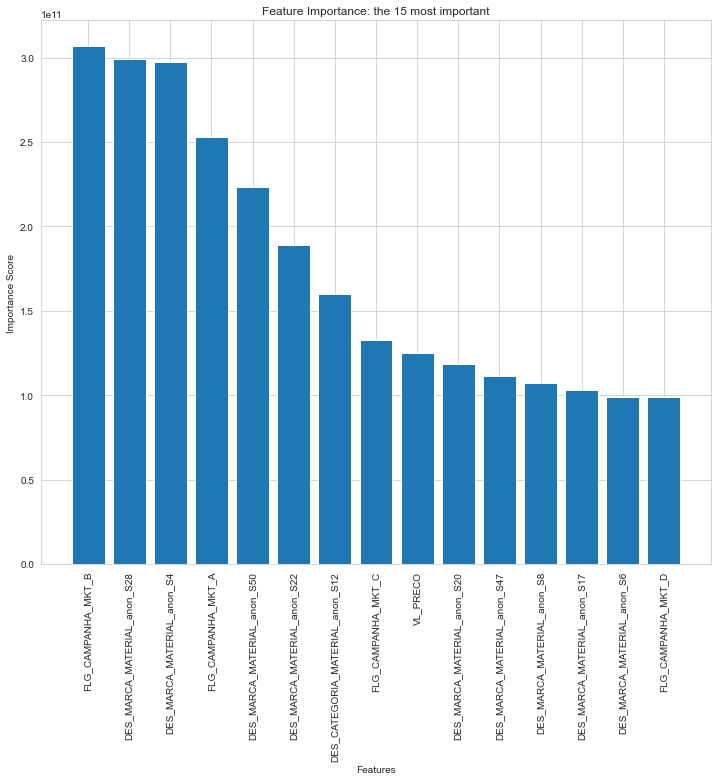

In [141]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(features[:15], scores[:15])
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance: the 15 most important')
plt.xticks(rotation=90)
plt.show()

In [79]:
#plot da série temporal para o conjunto teste
test_xgb = pd.concat([X_test, y_test], axis=1)
test_xgb['forecast'] = preds

In [80]:
test_xgb.head()

,COD_CICLO,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,VL_PRECO,DES_CATEGORIA_MATERIAL_anon_S12,...,DES_MARCA_MATERIAL_anon_S21,DES_MARCA_MATERIAL_anon_S22,DES_MARCA_MATERIAL_anon_S23,DES_MARCA_MATERIAL_anon_S24,DES_MARCA_MATERIAL_anon_S4,DES_MARCA_MATERIAL_anon_S6,DES_MARCA_MATERIAL_anon_S8,DES_MARCA_MATERIAL_anon_S9,QT_VENDA,forecast
47978,202015,0,0.0,0.0,0.0,0.0,0.0,0.0,611.400,0,...,0,0,0,0,0,0,1,0,1944.0,8857.250977
16616,201818,1,0.0,0.0,0.0,0.0,0.0,0.0,413.400,0,...,0,0,0,0,0,0,0,0,240.0,17276.761719
20726,201904,0,0.0,0.0,0.0,0.0,0.0,0.0,413.400,0,...,0,0,0,0,0,0,0,0,54666.0,5745.036133
28298,201912,0,0.0,1.0,0.0,0.5,0.0,0.0,496.635,0,...,0,0,0,0,0,0,1,0,44016.0,161475.203125
45590,202012,0,0.0,0.0,0.0,0.0,0.0,0.0,479.820,0,...,0,0,0,0,0,0,0,0,1188.0,4714.774902


<AxesSubplot:xlabel='COD_CICLO', ylabel='QT_VENDA'>

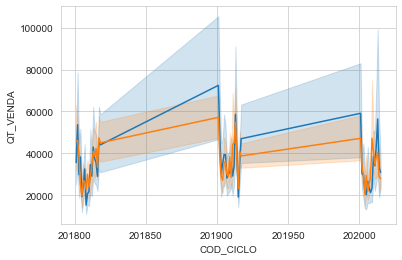

In [81]:
sns.lineplot(data=test_xgb, x='COD_CICLO', y='QT_VENDA')
sns.lineplot(data=test_xgb, x='COD_CICLO', y='forecast')

In [99]:
# predição da quantidade de venda para os ciclos 202016, 202017 e 202101
new_data = df[df['COD_CICLO'].isin([202016, 202017, 202101])].drop({'QT_VENDA', 'PCT_DESCONTO', 'COD_MATERIAL'}, axis=1)
new_data = pd.get_dummies(data=new_data, columns=['DES_CATEGORIA_MATERIAL','DES_MARCA_MATERIAL'], drop_first=True)
new_data.head()

,COD_CICLO,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,VL_PRECO,DES_CATEGORIA_MATERIAL_anon_S12,...,DES_MARCA_MATERIAL_anon_S17,DES_MARCA_MATERIAL_anon_S20,DES_MARCA_MATERIAL_anon_S21,DES_MARCA_MATERIAL_anon_S22,DES_MARCA_MATERIAL_anon_S23,DES_MARCA_MATERIAL_anon_S24,DES_MARCA_MATERIAL_anon_S4,DES_MARCA_MATERIAL_anon_S6,DES_MARCA_MATERIAL_anon_S8,DES_MARCA_MATERIAL_anon_S9
29,202101,0,0.0,0.0,0.0,0.0,0.0,0.0,791.4,1,...,0,0,0,0,0,0,0,0,0,0
47,202016,1,0.0,0.0,0.0,0.0,0.0,0.0,863.4,1,...,0,0,0,0,0,0,0,0,0,0
48,202101,0,0.0,0.0,0.0,0.0,0.0,0.0,863.4,1,...,0,0,0,0,0,0,0,0,0,0
113,202016,1,0.0,0.0,0.0,0.0,0.0,0.0,809.4,1,...,0,0,0,0,0,0,0,0,0,0
114,202017,1,0.0,0.0,0.0,0.0,0.0,0.0,809.4,1,...,0,0,0,0,0,0,0,0,0,0


In [100]:
data = xgb.DMatrix(new_data)
preds_new = xgboost.predict(data)
preds_new

array([ 19839.176,  31926.02 ,  29512.701, ..., 257068.11 , 221297.89 ,
       331899.16 ], dtype=float32)

In [103]:
preds_n = pd.DataFrame(preds_new, columns=['Predicted Values'])
preds_n.to_excel('data/forecasted_values.xlsx', index=False)

## Execução dos scripts

In [1]:
%run preprocess.py

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Started preprocess step at 10:12:34
Handling missing values
Encoding categorical variables
Train set with 39152 rows
Test set with 9788 rows
Dropping unecessary columns
Saving sets to csv
Finished Preprocess step at 10:12:36


In [2]:
%run train.py

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: Future

Started Train step at 10:12:41
Reading train and test sets
Training dataset
[0]	train-rmse:101904.10938	eval-rmse:85968.62500
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:97382.64844	eval-rmse:82979.02344
[2]	train-rmse:93461.34375	eval-rmse:80507.48438
[3]	train-rmse:89886.90625	eval-rmse:78515.92969
[4]	train-rmse:86663.18750	eval-rmse:76802.09375
[5]	train-rmse:83912.90625	eval-rmse:75503.17188
[6]	train-rmse:81660.94531	eval-rmse:74349.27344
[7]	train-rmse:79685.21094	eval-rmse:73505.04688
[8]	train-rmse:77830.31250	eval-rmse:72764.61719
[9]	train-rmse:76252.27344	eval-rmse:72266.17188
[10]	train-rmse:74654.98438	eval-rmse:71525.00000
[11]	train-rmse:73308.53906	eval-rmse:70931.45312
[12]	train-rmse:72109.73438	eval-rmse:70561.73438
[13]	train-rmse:70787.66406	eval-rmse:70239.89844
[14]	train-rmse:69805.23438	eval-rmse:69994.92969
[15]	train-rmse:68992.32812	eval-rmse:69

In [1]:
import pandas as pd
df = pd.read_csv('output.csv')
new_data = df[df['COD_CICLO'].isin([202016, 202017, 202101])]
new_data.head()

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
29,7098,202101,anon_S12,anon_S45,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,791.4,NaN
47,7230,202016,anon_S12,anon_S42,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,863.4,NaN
48,7230,202101,anon_S12,anon_S42,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,863.4,NaN
113,10104,202016,anon_S12,anon_S47,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,809.4,NaN
114,10104,202017,anon_S12,anon_S47,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,809.4,NaN


In [2]:
from inference import predict_xgb

/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/grasiele/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: Future

In [3]:
predict_xgb(new_data)

/Users/grasiele/Dropbox/Mac/Documents/case-study-forecasting/inference.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns={'PCT_DESCONTO', 'COD_MATERIAL', 'QT_VENDA'}, inplace=True)
/Users/grasiele/Dropbox/Mac/Documents/case-study-forecasting/inference.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


['COD_CICLO', 'FLG_DATA', 'FLG_CAMPANHA_MKT_A', 'FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D', 'FLG_CAMPANHA_MKT_E', 'FLG_CAMPANHA_MKT_F', 'VL_PRECO', 'DES_CATEGORIA_MATERIAL_anon_S12', 'DES_CATEGORIA_MATERIAL_anon_S18', 'DES_CATEGORIA_MATERIAL_anon_S2', 'DES_CATEGORIA_MATERIAL_anon_S30', 'DES_CATEGORIA_MATERIAL_anon_S5', 'DES_MARCA_MATERIAL_anon_S14', 'DES_MARCA_MATERIAL_anon_S15', 'DES_MARCA_MATERIAL_anon_S16', 'DES_MARCA_MATERIAL_anon_S17', 'DES_MARCA_MATERIAL_anon_S19', 'DES_MARCA_MATERIAL_anon_S20', 'DES_MARCA_MATERIAL_anon_S21', 'DES_MARCA_MATERIAL_anon_S22', 'DES_MARCA_MATERIAL_anon_S23', 'DES_MARCA_MATERIAL_anon_S24', 'DES_MARCA_MATERIAL_anon_S25', 'DES_MARCA_MATERIAL_anon_S26', 'DES_MARCA_MATERIAL_anon_S27', 'DES_MARCA_MATERIAL_anon_S28', 'DES_MARCA_MATERIAL_anon_S29', 'DES_MARCA_MATERIAL_anon_S3', 'DES_MARCA_MATERIAL_anon_S31', 'DES_MARCA_MATERIAL_anon_S32', 'DES_MARCA_MATERIAL_anon_S33', 'DES_MARCA_MATERIAL_anon_S34', 'DES_MARCA_MATERIAL_anon_S35', 'DES_MA

/Users/grasiele/Dropbox/Mac/Documents/case-study-forecasting/inference.py:60: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  preds.to_excel('data/forecasted_values.xlsx', index=False)


,Predicted Values
0,20208.777344
1,20888.978516
2,17128.675781
3,24095.796875
4,24095.796875
...,...
3143,25100.943359
3144,50328.218750
3145,202021.718750
3146,203727.078125
